In [20]:
# ------------------------
# Standard Library Imports
# ------------------------
import os
import re
import ast
import json
from functools import reduce

# ------------------------
# Third-Party Imports
# ------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# FastAI
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.metrics import accuracy
from fastai.losses import CrossEntropyLossFlat
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback

# MONAI
from monai.networks.nets import resnet18

# XGBoost
import xgboost as xgb

# scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%matplotlib inline

In [21]:
import pandas as pd

###########################################################
# 1) Load Aortic Distensibility
###########################################################
asc_aorta_dist = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24120.csv')
asc_aorta_dist = asc_aorta_dist.rename(
    columns={'eid': 'IID', '24120-2.0': 'asc_aorta_dist'}
)[['IID', 'asc_aorta_dist']]

desc_aorta_dist = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24123.csv')
desc_aorta_dist = desc_aorta_dist.rename(
    columns={'eid': 'IID', '24123-2.0': 'desc_aorta_dist'}
)[['IID', 'desc_aorta_dist']]

###########################################################
# 2) Load LV Structure & Function
###########################################################
# LV ejection fraction
lv_ef = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24103.csv')
lv_ef = lv_ef.rename(columns={'eid': 'IID', '24103-2.0': 'lv_ejection_fraction'})[['IID', 'lv_ejection_fraction']]

# LV end diastolic volume
lv_edv = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24100.csv')
lv_edv = lv_edv.rename(columns={'eid': 'IID', '24100-2.0': 'lv_end_diastolic_vol'})[['IID', 'lv_end_diastolic_vol']]

# LV end systolic volume
lv_esv = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24101.csv')
lv_esv = lv_esv.rename(columns={'eid': 'IID', '24101-2.0': 'lv_end_systolic_vol'})[['IID', 'lv_end_systolic_vol']]

# LV stroke volume
lv_sv = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24102.csv')
lv_sv = lv_sv.rename(columns={'eid': 'IID', '24102-2.0': 'lv_stroke_vol'})[['IID', 'lv_stroke_vol']]

# LV myocardial mass
lv_mass = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24105.csv')
lv_mass = lv_mass.rename(columns={'eid': 'IID', '24105-2.0': 'lv_myocardial_mass'})[['IID', 'lv_myocardial_mass']]

###########################################################
# 3) Load LV Deformation (Strain) Metrics
###########################################################
# LV circumferential strain (global)
lv_circ_strain_global = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24157.csv')
lv_circ_strain_global = lv_circ_strain_global.rename(
    columns={'eid': 'IID', '24157-2.0': 'lv_circ_strain_global'}
)[['IID', 'lv_circ_strain_global']]

# LV radial strain (global)
lv_rad_strain_global = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24174.csv')
lv_rad_strain_global = lv_rad_strain_global.rename(
    columns={'eid': 'IID', '24174-2.0': 'lv_rad_strain_global'}
)[['IID', 'lv_rad_strain_global']]

# LV longitudinal strain (global)
lv_long_strain_global = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24181.csv')
lv_long_strain_global = lv_long_strain_global.rename(
    columns={'eid': 'IID', '24181-2.0': 'lv_long_strain_global'}
)[['IID', 'lv_long_strain_global']]

###########################################################
# 4) Load LV Wall Thickness (Global)
###########################################################
lv_wall_thick_global = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid24140.csv')
lv_wall_thick_global = lv_wall_thick_global.rename(
    columns={'eid': 'IID', '24140-2.0': 'lv_mean_wall_thick_global'}
)[['IID', 'lv_mean_wall_thick_global']]

###########################################################
# 5) Merge Everything Together
#
#    Start by merging Asc/Desc Aorta Distensibility,
#    then merge each LV phenotype DataFrame.
###########################################################
df_IDP = asc_aorta_dist.merge(desc_aorta_dist, on='IID', how='inner')

# Merge LV Structure/Function
df_IDP = df_IDP.merge(lv_ef, on='IID', how='inner')
df_IDP = df_IDP.merge(lv_edv, on='IID', how='inner')
df_IDP = df_IDP.merge(lv_esv, on='IID', how='inner')
df_IDP = df_IDP.merge(lv_sv, on='IID', how='inner')
df_IDP = df_IDP.merge(lv_mass, on='IID', how='inner')

# Merge LV Strain Metrics
df_IDP = df_IDP.merge(lv_circ_strain_global, on='IID', how='inner')
df_IDP = df_IDP.merge(lv_rad_strain_global, on='IID', how='inner')
df_IDP = df_IDP.merge(lv_long_strain_global, on='IID', how='inner')

# Merge LV Wall Thickness
df_IDP = df_IDP.merge(lv_wall_thick_global, on='IID', how='inner')

###########################################################
# 6) Optionally drop any rows with missing values
###########################################################
df_IDP = df_IDP.dropna()

# Inspect the results
print(df_IDP.head())
print(df_IDP.shape)


         IID  asc_aorta_dist  desc_aorta_dist  lv_ejection_fraction  \
29   1000308        0.828266          1.57136               52.8080   
31   1000320        2.092870          1.31435               52.2918   
58   1000592        1.402850          1.75219               74.1529   
94   1000951        1.141200          1.18064               25.2290   
101  1001025        1.252640          2.63028               60.6075   

     lv_end_diastolic_vol  lv_end_systolic_vol  lv_stroke_vol  \
29                150.361              70.9584        79.4026   
31                119.200              56.8680        62.3317   
58                160.524              41.4908       119.0330   
94                167.617             125.3290        42.2880   
101               137.344              54.1033        83.2409   

     lv_myocardial_mass  lv_circ_strain_global  lv_rad_strain_global  \
29             118.0680              -19.83460               40.5551   
31              82.7395              -

In [22]:
# Now `df` contains all relevant columns
df_IDP.head()

,IID,asc_aorta_dist,desc_aorta_dist,lv_ejection_fraction,lv_end_diastolic_vol,lv_end_systolic_vol,lv_stroke_vol,lv_myocardial_mass,lv_circ_strain_global,lv_rad_strain_global,lv_long_strain_global,lv_mean_wall_thick_global
29,1000308,0.828266,1.57136,52.8080,150.361,70.9584,79.4026,118.0680,-19.83460,40.5551,-16.9287,7.16532
31,1000320,2.092870,1.31435,52.2918,119.200,56.8680,62.3317,82.7395,-18.63010,43.3131,-13.4075,6.61503
58,1000592,1.402850,1.75219,74.1529,160.524,41.4908,119.0330,123.2860,-32.77460,55.0223,-18.7139,6.81957
94,1000951,1.141200,1.18064,25.2290,167.617,125.3290,42.2880,107.3090,-8.11443,16.7313,-10.1798,7.11347
101,1001025,1.252640,2.63028,60.6075,137.344,54.1033,83.2409,69.7752,-20.54680,45.5338,-15.8644,4.80620


In [23]:
len(df_IDP)

32539

In [24]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col):
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col}).drop_duplicates()
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    return df



# Process train data for each channel
train_fin = load_and_process('train_embeddings_long_axis_ch0_imbalanced_monai.csv', 'embedding0')
train_fin1 = load_and_process('train_embeddings_long_axis_ch1_imbalanced_monai.csv', 'embedding1')
train_fin2 = load_and_process('train_embeddings_long_axis_ch2_imbalanced_monai.csv', 'embedding2')

# Merge train DataFrames
train_df_x = pd.merge(train_fin, train_fin1, on=['image_path', 'label'], how='inner')
train_df_heart = pd.merge(train_df_x, train_fin2, on=['image_path', 'label'], how='inner')

# Extract IID from image path for train
train_df_heart['IID'] = train_df_heart['image_path'].str.extract(r'Processed/(\d+).npy').astype(int)

# Process test data for each channel
test_fin = load_and_process('test_embeddings_long_axis_ch0_imbalanced_monai.csv', 'embedding0')
test_fin1 = load_and_process('test_embeddings_long_axis_ch1_imbalanced_monai.csv', 'embedding1')
test_fin2 = load_and_process('test_embeddings_long_axis_ch2_imbalanced_monai.csv', 'embedding2')

# Merge test DataFrames
test_df_x = pd.merge(test_fin, test_fin1, on=['image_path', 'label'], how='inner')
test_df_heart = pd.merge(test_df_x, test_fin2, on=['image_path', 'label'], how='inner')

# Extract IID from image path for test
test_df_heart['IID'] = test_df_heart['image_path'].str.extract(r'Processed/(\d+).npy').astype(int)

# Print results (optional, for verification)
print(train_df_heart['label'].value_counts())
print(test_df_heart['label'].value_counts())

label
0    26358
1     4391
Name: count, dtype: int64
label
0    200
1    200
Name: count, dtype: int64


In [25]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col):
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col}).drop_duplicates()
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    return df

# Process train and test datasets
train_df_aortic = load_and_process('train_embeddings_aortic_monai.csv', 'aortic_embeddings')
test_df_aortic = load_and_process('test_embeddings_aortic_monai.csv', 'aortic_embeddings')

# Extract IID from image path for both train and test
train_df_aortic['IID'] = train_df_aortic['image_path'].str.extract(r'/(\d+)_\d+\.npy').astype(int)
test_df_aortic['IID'] = test_df_aortic['image_path'].str.extract(r'/(\d+)_\d+\.npy').astype(int)  # Fixed parentheses

# Print results (optional, for verification)
print(train_df_aortic['label'].value_counts())
print(test_df_aortic['label'].value_counts())

label
0    3287
1    3287
Name: count, dtype: int64
label
0    200
1    200
Name: count, dtype: int64


In [26]:
# List of datasets to merge sequentially
datasets = [
    train_df_heart,
    train_df_aortic
]

# Drop the 'image path' column if it exists in any dataset
datasets = [df.drop(columns=['image_path'], errors='ignore') for df in datasets]


train_df_full = reduce(lambda left, right: pd.merge(left, right, on=['IID', 'label'], how='inner'), datasets)

# Display the resulting dataframe
train_df_full.head()

,embedding0,label,embedding1,embedding2,IID,aortic_embeddings
0,"[0.6222007274627686, 0.857754111289978, 0.8616003394126892, 0.883907675743103, 0.8197298645973206, 1.445050835609436, 0.7749342322349548, 1.3935546875, 0.8606221675872803, 0.925336480140686, 1.041946530342102, 0.9229991436004639, 0.763674259185791, 0.48203182220458984, 0.8501312136650085, 1.1560198068618774, 1.5509973764419556, 0.584078848361969, 1.2906135320663452, 0.8675865530967712, 0.851374089717865, 1.0265535116195679, 0.8038004636764526, 0.8011053204536438, 0.998083770275116, 0.4229792356491089, 0.3374080955982208, 0.8993629813194275, 0.7269145846366882, 0.6914081573486328, 0.9002788...",0,"[0.9138720631599426, 0.8331859707832336, 1.7107104063034058, 0.36827000975608826, 0.7582360506057739, 0.8271345496177673, 0.5451690554618835, 1.791560411453247, 0.5653491020202637, 1.1475237607955933, 0.9976169466972351, 0.9246202111244202, 1.9436131715774536, 0.6524003148078918, 1.6679643392562866, 0.8552929162979126, 1.0772122144699097, 0.3189797103404999, 1.96384596824646, 1.1218271255493164, 0.5678544044494629, 0.6917015314102173, 1.0978221893310547, 0.909571647644043, 1.031683325767517, 1.0978484153747559, 0.8492335677146912, 1.3887768983840942, 0.9612007737159729, 1.157508373260498, ...","[0.8524302840232849, 1.5004643201828003, 0.8820369839668274, 0.6462464332580566, 0.6083031892776489, 0.7628796696662903, 1.317216157913208, 0.6307762861251831, 0.8806958794593811, 0.8145623207092285, 0.7839545011520386, 0.8731969594955444, 0.6858144998550415, 0.9177017211914062, 1.0565109252929688, 1.063869833946228, 1.3381705284118652, 0.5501223802566528, 0.9968410730361938, 0.37457430362701416, 0.9705101251602173, 1.0586310625076294, 0.939874529838562, 1.066116452217102, 0.7345121502876282, 0.3118692934513092, 1.06654691696167, 0.8911469578742981, 0.3591005206108093, 0.7956545948982239, ...",3267458,"[1.099939227104187, 0.8363233208656311, 0.7002729773521423, 1.1575764417648315, 0.8180968165397644, 0.8294677734375, 0.8655126094818115, 0.6992030143737793, 0.923823893070221, 1.9807233810424805, 0.7115509510040283, 0.9140763282775879, 0.6039851307868958, 0.8474515676498413, 1.1692769527435303, 1.9573605060577393, 0.5059712529182434, 2.048501491546631, 0.792567253112793, 1.7016417980194092, 0.6947299838066101, 2.0984816551208496, 1.1111807823181152, 0.9727722406387329, 0.9552590847015381, 0.5849677920341492, 2.313647747039795, 1.956329345703125, 0.6721970438957214, 0.9292367100715637, 0.92..."
1,"[0.8524421453475952, 1.1529635190963745, 0.9273219108581543, 1.3484241962432861, 0.9488350749015808, 1.3672786951065063, 0.4505791962146759, 1.2266489267349243, 1.039737343788147, 1.4517909288406372, 1.3201881647109985, 1.1502001285552979, 1.2937198877334595, 0.4957474172115326, 0.6454839110374451, 1.1808773279190063, 1.2069627046585083, 0.6448122262954712, 1.394805908203125, 0.9780712127685547, 1.0762056112289429, 1.5468693971633911, 1.1778465509414673, 0.8933378458023071, 0.6201441287994385, 0.8116099834442139, 0.43900540471076965, 2.078183174133301, 0.6782131195068359, 0.872504234313964...",0,"[0.8691175580024719, 1.1014518737792969, 1.9534063339233398, 0.6436268091201782, 0.89743572473526, 1.1686769723892212, 0.5253512263298035, 2.2300102710723877, 0.5054740309715271, 1.6518757343292236, 1.4155858755111694, 0.9398287534713745, 1.8867213726043701, 0.7935408353805542, 1.7156667709350586, 1.3425205945968628, 0.8849124908447266, 0.4572778642177582, 2.5848190784454346, 1.0044329166412354, 0.46342772245407104, 0.8587211966514587, 0.8859243392944336, 1.095733880996704, 1.3933234214782715, 1.6633275747299194, 0.918140709400177, 1.6232742071151733, 1.1541357040405273, 1.2664389610290527...","[0.7155594825744629, 1.5444616079330444, 1.2311761379241943, 0.6855605840682983, 0.7418147325515747, 0.8684224486351013, 1.4161876440048218, 0.7957673072814941, 1.0722490549087524, 1.0012319087982178, 0.8967545032501221, 1.258593201637268, 0.8206250667572021, 0.7057670950889587, 0.7986931800842285, 0.9378591

In [27]:
# List of test datasets to merge sequentially
test_datasets = [
    test_df_heart,
    test_df_aortic
]

# Drop the 'image path' column if it exists in any dataset
test_datasets = [df.drop(columns=['image_path'], errors='ignore') for df in test_datasets]

test_df_full = reduce(lambda left, right: pd.merge(left, right, on=['IID', 'label'], how='inner'), test_datasets)

# Display the resulting dataframe
test_df_full.head()

,embedding0,label,embedding1,embedding2,IID,aortic_embeddings
0,"[1.0895754098892212, 1.2075629234313965, 1.0482062101364136, 0.9118613004684448, 1.0740480422973633, 1.136765718460083, 0.6958901286125183, 0.965225875377655, 0.6389136910438538, 0.8471961617469788, 1.0300726890563965, 0.9517812728881836, 0.8857521414756775, 0.5699324011802673, 0.6920090913772583, 0.9720370173454285, 1.0127886533737183, 0.6003158092498779, 1.1979175806045532, 0.8739647269248962, 0.9994410276412964, 1.028313398361206, 1.2683802843093872, 1.0019876956939697, 0.8166642189025879, 0.6921669840812683, 0.5523523688316345, 1.1348984241485596, 1.096311330795288, 1.224096655845642, ...",0,"[0.5463781356811523, 0.9533547163009644, 1.7026994228363037, 0.7883009314537048, 0.7034727334976196, 1.1759182214736938, 0.5248373746871948, 1.7175720930099487, 0.4877365231513977, 1.321129560470581, 1.2640970945358276, 0.9619779586791992, 1.581677794456482, 0.8017070293426514, 1.5566812753677368, 1.1194970607757568, 1.0191187858581543, 0.7601537704467773, 1.8609097003936768, 1.0081110000610352, 0.7693869471549988, 0.8575429320335388, 0.9163612127304077, 1.0850476026535034, 1.1360541582107544, 1.0152785778045654, 0.8050270676612854, 1.587085247039795, 1.0466598272323608, 1.5571528673171997...","[1.0024220943450928, 1.2877448797225952, 1.0760911703109741, 0.8490594029426575, 0.7693535089492798, 0.9796526432037354, 1.034644603729248, 0.8943065404891968, 1.092765212059021, 0.9919499754905701, 0.7121495604515076, 0.908539891242981, 0.7652375102043152, 0.5391296148300171, 0.7972453832626343, 0.7974820137023926, 0.8698428273200989, 0.5601634383201599, 0.9110758304595947, 0.738475501537323, 0.8436992168426514, 0.9588451385498047, 1.0914881229400635, 1.1504780054092407, 0.9125434756278992, 0.5120255351066589, 0.7696884870529175, 0.8374080657958984, 0.4776846468448639, 0.5961804986000061,...",4890586,"[1.4666997194290161, 0.8146945238113403, 0.733342707157135, 1.2061903476715088, 1.033097743988037, 0.7839332222938538, 0.7298247814178467, 0.9608491063117981, 0.9573360681533813, 1.9833619594573975, 0.8644430041313171, 0.8587613701820374, 0.9218736290931702, 0.8825300335884094, 1.4846101999282837, 2.031212568283081, 0.3615342676639557, 2.580281972885132, 0.6737241744995117, 1.6512433290481567, 0.7470093965530396, 2.1212751865386963, 1.3927825689315796, 1.0097768306732178, 1.152884602546692, 0.7125040292739868, 2.390376091003418, 2.0995235443115234, 1.0365688800811768, 0.7167155742645264, 1..."
1,"[0.7500353455543518, 0.5545405745506287, 0.8633346557617188, 1.129804015159607, 0.7132244110107422, 0.8481082320213318, 1.1301276683807373, 0.8960837125778198, 0.8930218815803528, 0.7139872908592224, 1.0768547058105469, 0.8585430383682251, 0.8573217391967773, 0.5256759524345398, 1.2447184324264526, 0.6619812846183777, 1.648592233657837, 0.6669840812683105, 1.3122608661651611, 0.9024937748908997, 0.6398782134056091, 1.0942362546920776, 0.4958614408969879, 0.6821052432060242, 0.8107386827468872, 0.4888327717781067, 0.6771814823150635, 0.667090892791748, 0.5666688084602356, 0.7489054203033447...",0,"[0.8292922973632812, 0.8665534853935242, 1.3418996334075928, 0.6883587837219238, 0.9956488609313965, 0.9123938083648682, 0.8507362604141235, 1.6286911964416504, 0.6662888526916504, 0.9029881954193115, 1.0247138738632202, 0.8148752450942993, 1.4381495714187622, 0.6724014282226562, 1.3020637035369873, 1.054136037826538, 1.0562806129455566, 0.49558717012405396, 1.1238048076629639, 1.0568218231201172, 0.6940033435821533, 0.7981842160224915, 0.969775915145874, 0.8129621744155884, 1.0214080810546875, 0.9789760112762451, 0.987311840057373, 1.1790043115615845, 0.7883342504501343, 1.037059783935546...","[0.7049407958984375, 0.8878511786460876, 0.8063250184059143, 0.8746635317802429, 0.7917676568031311, 0.8912169337272644, 0.8110095858573914, 0.6371435523033142, 0.8278197050094604, 0.7272440791130066, 0.6261743903160095, 0.5535633563995361, 0.7530847787857056, 0.7431906461715698, 1.0201128721237183, 1.013735

In [28]:
def convert_to_array(embedding):
    """
    Converts a string representation of a list into a NumPy array.
    
    Args:
        embedding (str or list): Embedding to convert.
        
    Returns:
        np.ndarray: Converted embedding.
    """
    if isinstance(embedding, str):
        return np.array(ast.literal_eval(embedding))  # Safely parse string to list
    elif isinstance(embedding, (list, np.ndarray)):
        return np.array(embedding)
    else:
        raise ValueError(f"Unsupported embedding format: {type(embedding)}")

In [29]:
def fit_pca_on_train(df, embedding_cols, n_components=10):
    """
    Fits PCA on the train embeddings and adds PCA-transformed features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the embeddings.
        embedding_cols (list of str): Column names with embeddings.
        n_components (int): Number of PCA components to fit.

    Returns:
        tuple: Updated DataFrame with PCA features and a dictionary of fitted PCA objects.
    """
    pca_dict = {}
    for col in embedding_cols:
        # Ensure the embeddings are numpy arrays
        embeddings = np.vstack(df[col].values)
        
        # Fit PCA
        pca = PCA(n_components=n_components)
        pca.fit(embeddings)
        pca_dict[col] = pca
        
        # Transform and add PCA features to the DataFrame
        pca_features = pca.transform(embeddings)
        pca_feature_cols = [f'pca_{col}_{i+1}' for i in range(n_components)]
        df[pca_feature_cols] = pca_features
    
    return df, pca_dict

In [30]:
def transform_embeddings_with_pca(df, embedding_cols, pca_dict):
    """
    Transforms embeddings using pre-fitted PCA and adds PCA features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the embeddings to transform.
        embedding_cols (list of str): Column names with embeddings.
        pca_dict (dict): Dictionary of pre-fitted PCA objects for each column.

    Returns:
        pd.DataFrame: Updated DataFrame with PCA-transformed features added.
    """
    for col in embedding_cols:
        # Ensure the embeddings are numpy arrays
        embeddings = np.vstack(df[col].values)
        
        # Transform using the pre-fitted PCA
        pca = pca_dict[col]
        pca_features = pca.transform(embeddings)
        
        # Add PCA features to the DataFrame
        pca_feature_cols = [f'pca_{col}_{i+1}' for i in range(pca.n_components)]
        df[pca_feature_cols] = pca_features
    
    return df

In [31]:
# Embedding Columns and PCA
embedding_columns = [
    'embedding0', 
    'embedding1', 
    'embedding2', 
    'aortic_embeddings'
    
]
# Convert all embeddings to NumPy arrays
for col in embedding_columns:
    train_df_full[col] = train_df_full[col].apply(convert_to_array)


emb_columns  = [col for col in train_df_full.columns if 'embedding' in col.lower()]

# Perform PCA on the embedding columns
train_df_full, pca_dict = fit_pca_on_train(train_df_full, embedding_columns)


# Generate PCA columns dynamically
pca_columns = [f'pca_{col}_{i+1}' for col in embedding_columns for i in range(10)]



# Select relevant columns for analysis
columns_to_keep = [
    'IID', 'label'
] + pca_columns +emb_columns
train_df = train_df_full[columns_to_keep]

In [32]:
train_df.head()

,IID,label,pca_embedding0_1,pca_embedding0_2,pca_embedding0_3,pca_embedding0_4,pca_embedding0_5,pca_embedding0_6,pca_embedding0_7,pca_embedding0_8,...,pca_aortic_embeddings_5,pca_aortic_embeddings_6,pca_aortic_embeddings_7,pca_aortic_embeddings_8,pca_aortic_embeddings_9,pca_aortic_embeddings_10,embedding0,embedding1,embedding2,aortic_embeddings
0,3267458,0,-1.266902,3.527158,0.069286,-0.095203,0.462511,1.007084,0.694949,0.112731,...,-0.125780,0.157037,-0.207324,0.468580,-0.117212,0.095138,"[0.6222007274627686, 0.857754111289978, 0.8616003394126892, 0.883907675743103, 0.8197298645973206, 1.445050835609436, 0.7749342322349548, 1.3935546875, 0.8606221675872803, 0.925336480140686, 1.041946530342102, 0.9229991436004639, 0.763674259185791, 0.48203182220458984, 0.8501312136650085, 1.1560198068618774, 1.5509973764419556, 0.584078848361969, 1.2906135320663452, 0.8675865530967712, 0.851374089717865, 1.0265535116195679, 0.8038004636764526, 0.8011053204536438, 0.998083770275116, 0.4229792356491089, 0.3374080955982208, 0.8993629813194275, 0.7269145846366882, 0.6914081573486328, 0.9002788...","[0.9138720631599426, 0.8331859707832336, 1.7107104063034058, 0.36827000975608826, 0.7582360506057739, 0.8271345496177673, 0.5451690554618835, 1.791560411453247, 0.5653491020202637, 1.1475237607955933, 0.9976169466972351, 0.9246202111244202, 1.9436131715774536, 0.6524003148078918, 1.6679643392562866, 0.8552929162979126, 1.0772122144699097, 0.3189797103404999, 1.96384596824646, 1.1218271255493164, 0.5678544044494629, 0.6917015314102173, 1.0978221893310547, 0.909571647644043, 1.031683325767517, 1.0978484153747559, 0.8492335677146912, 1.3887768983840942, 0.9612007737159729, 1.157508373260498, ...","[0.8524302840232849, 1.5004643201828003, 0.8820369839668274, 0.6462464332580566, 0.6083031892776489, 0.7628796696662903, 1.317216157913208, 0.6307762861251831, 0.8806958794593811, 0.8145623207092285, 0.7839545011520386, 0.8731969594955444, 0.6858144998550415, 0.9177017211914062, 1.0565109252929688, 1.063869833946228, 1.3381705284118652, 0.5501223802566528, 0.9968410730361938, 0.37457430362701416, 0.9705101251602173, 1.0586310625076294, 0.939874529838562, 1.066116452217102, 0.7345121502876282, 0.3118692934513092, 1.06654691696167, 0.8911469578742981, 0.3591005206108093, 0.7956545948982239, ...","[1.099939227104187, 0.8363233208656311, 0.7002729773521423, 1.1575764417648315, 0.8180968165397644, 0.8294677734375, 0.8655126094818115, 0.6992030143737793, 0.923823893070221, 1.9807233810424805, 0.7115509510040283, 0.9140763282775879, 0.6039851307868958, 0.8474515676498413, 1.1692769527435303, 1.9573605060577393, 0.5059712529182434, 2.048501491546631, 0.792567253112793, 1.7016417980194092, 0.6947299838066101, 2.0984816551208496, 1.1111807823181152, 0.9727722406387329, 0.9552590847015381, 0.5849677920341492, 2.313647747039795, 1.956329345703125, 0.6721970438957214, 0.9292367100715637, 0.92..."
1,4086644,0,3.624096,1.569670,-1.502169,2.064160,0.319388,0.457664,0.692098,-0.177135,...,0.782412,-0.282954,-0.077760,0.386226,0.235222,0.103551,"[0.8524421453475952, 1.1529635190963745, 0.9273219108581543, 1.3484241962432861, 0.9488350749015808, 1.3672786951065063, 0.4505791962146759, 1.2266489267349243, 1.039737343788147, 1.4517909288406372, 1.3201881647109985, 1.1502001285552979, 1.2937198877334595, 0.4957474172115326, 0.6454839110374451, 1.1808773279190063, 1.2069627046585083, 0.6448122262954712, 1.394805908203125, 0.9780712127685547, 1.0762056112289429, 1.5468693971633911, 1.1778465509414673, 0.8933378458023071, 0.6201441287994385, 0.8116099834442139, 0.43900540471076965, 2.078183174133301, 0.6782131195068359, 0.872504234313964...","[0.8691175580024719, 1.1014518737792969, 1.9534063339233398, 0.6436268091201782, 0.89743572473526, 1.1686769723892212, 0.5253512263298035, 2.2300102710723877, 0.5054740309715271, 1.6518757343292236, 1.4155858755111694, 0.9398287534713745, 1.8867213726043701, 0.7935408353805542, 1.7156667709350586, 1.3425205945968628, 0.8849124908447266, 0.45727786

In [33]:
idp_df = pd.merge(train_df, df_IDP, on= 'IID', how = 'inner')

In [34]:
len(idp_df)

2472

In [35]:
idp_df['label'].value_counts()

label
1    1348
0    1124
Name: count, dtype: int64

In [36]:
idp_df.head()

,IID,label,pca_embedding0_1,pca_embedding0_2,pca_embedding0_3,pca_embedding0_4,pca_embedding0_5,pca_embedding0_6,pca_embedding0_7,pca_embedding0_8,...,desc_aorta_dist,lv_ejection_fraction,lv_end_diastolic_vol,lv_end_systolic_vol,lv_stroke_vol,lv_myocardial_mass,lv_circ_strain_global,lv_rad_strain_global,lv_long_strain_global,lv_mean_wall_thick_global
0,3267458,0,-1.266902,3.527158,0.069286,-0.095203,0.462511,1.007084,0.694949,0.112731,...,6.153310,59.1535,135.642,55.4050,80.2370,73.5951,-23.9410,42.0655,-22.20560,5.21963
1,4296851,1,-2.621979,-0.528482,1.645231,-0.338840,0.175094,-0.094409,-0.728999,0.354728,...,1.283410,66.1626,134.641,45.5589,89.0818,85.6157,-22.3108,58.2041,-19.81450,6.14186
2,2573600,1,-1.575722,-0.896626,0.362491,-1.074883,-0.652322,0.260218,-0.451811,0.753735,...,1.592830,56.9741,132.805,57.1405,75.6645,97.1456,-21.4895,34.9944,-16.41920,6.74947
3,1707186,0,-1.547730,3.083791,0.179703,0.190378,0.446294,-0.697199,-0.313572,-0.111845,...,1.973310,56.5104,153.031,66.5527,86.4785,78.3613,-15.3768,28.2324,-14.25400,5.17649
4,5052164,0,-4.830214,1.268930,1.258912,-1.073485,-0.505774,0.994028,-0.472616,-0.621707,...,0.677048,31.5396,174.292,119.3210,54.9711,125.1470,-12.3026,21.9359,-4.27648,7.49538


In [37]:
idp_df.columns

Index(['IID', 'label', 'pca_embedding0_1', 'pca_embedding0_2',
       'pca_embedding0_3', 'pca_embedding0_4', 'pca_embedding0_5',
       'pca_embedding0_6', 'pca_embedding0_7', 'pca_embedding0_8',
       'pca_embedding0_9', 'pca_embedding0_10', 'pca_embedding1_1',
       'pca_embedding1_2', 'pca_embedding1_3', 'pca_embedding1_4',
       'pca_embedding1_5', 'pca_embedding1_6', 'pca_embedding1_7',
       'pca_embedding1_8', 'pca_embedding1_9', 'pca_embedding1_10',
       'pca_embedding2_1', 'pca_embedding2_2', 'pca_embedding2_3',
       'pca_embedding2_4', 'pca_embedding2_5', 'pca_embedding2_6',
       'pca_embedding2_7', 'pca_embedding2_8', 'pca_embedding2_9',
       'pca_embedding2_10', 'pca_aortic_embeddings_1',
       'pca_aortic_embeddings_2', 'pca_aortic_embeddings_3',
       'pca_aortic_embeddings_4', 'pca_aortic_embeddings_5',
       'pca_aortic_embeddings_6', 'pca_aortic_embeddings_7',
       'pca_aortic_embeddings_8', 'pca_aortic_embeddings_9',
       'pca_aortic_embeddings_10'

/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is depr


=== Cross-Validation AUC and Accuracy ===
Model A (IDPs)             : AUC = 0.645 ± 0.009, Accuracy = 0.613 ± 0.015
Model B (Raw Embeddings)   : AUC = 0.500 ± 0.000, Accuracy = 0.545 ± 0.001
Model C (PCA Embeddings)   : AUC = 0.740 ± 0.020, Accuracy = 0.678 ± 0.024
Model A+B (IDPs + Raw Embs): AUC = 0.645 ± 0.009, Accuracy = 0.613 ± 0.015
Model A+C (IDPs + PCA)     : AUC = 0.750 ± 0.018, Accuracy = 0.681 ± 0.028


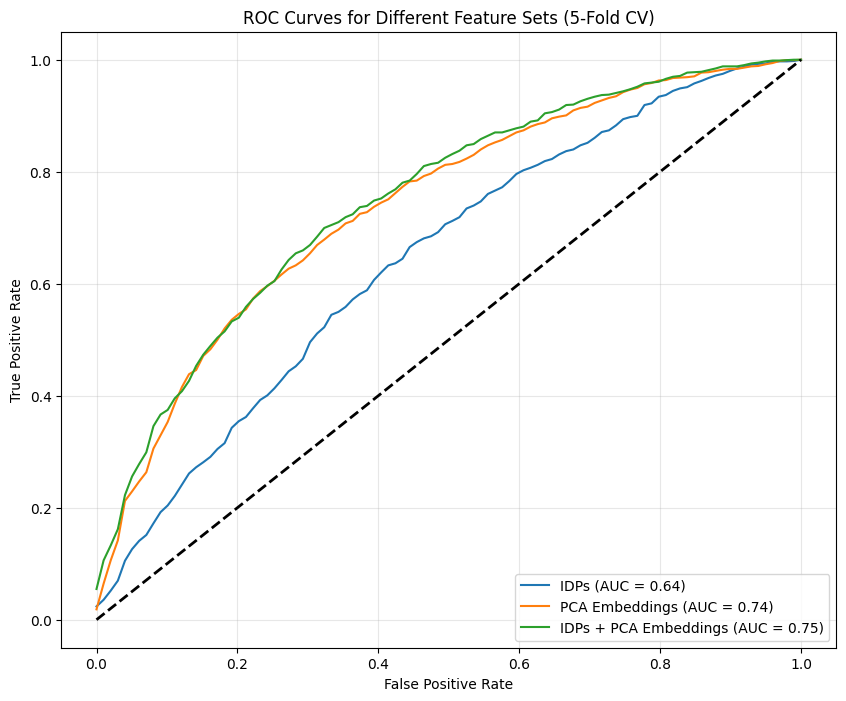

In [38]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

##############################################################################
# 1) Flatten Raw Embeddings into Separate Columns
##############################################################################
def expand_embedding_columns(df, col_name):
    """
    Expands a column containing 512-dimensional array embeddings into
    512 separate columns.
    """
    emb_matrix = np.vstack(df[col_name].apply(lambda x: np.array(x) if isinstance(x, list) else np.zeros(512)))
    emb_df = pd.DataFrame(emb_matrix, columns=[f"{col_name}_{i+1}" for i in range(512)])
    return emb_df

# Expand all 4 embedding vectors (512 each)
embedding0_df = expand_embedding_columns(idp_df, 'embedding0')
embedding1_df = expand_embedding_columns(idp_df, 'embedding1')
embedding2_df = expand_embedding_columns(idp_df, 'embedding2')
aortic_embeddings_df = expand_embedding_columns(idp_df, 'aortic_embeddings')

# Merge back into idp_df
idp_df = pd.concat([idp_df, embedding0_df, embedding1_df, embedding2_df, aortic_embeddings_df], axis=1)

##############################################################################
# 2) Identify Feature Groups
##############################################################################
idp_cols = [
    'asc_aorta_dist', 'desc_aorta_dist',
    'lv_ejection_fraction', 'lv_end_diastolic_vol', 'lv_end_systolic_vol',
    'lv_stroke_vol', 'lv_myocardial_mass',
    'lv_circ_strain_global', 'lv_rad_strain_global', 'lv_long_strain_global',
    'lv_mean_wall_thick_global'
]

# PCA Embedding columns
pca_embedding_cols = [col for col in idp_df.columns if 'pca_embedding' in col.lower()]

# Raw Embedding columns
raw_embedding_cols = embedding0_df.columns.tolist() + embedding1_df.columns.tolist() + embedding2_df.columns.tolist() + aortic_embeddings_df.columns.tolist()

label_col = 'label'  

##############################################################################
# 3) 5-Fold CV Function
##############################################################################
def cross_val_auc(X, y, n_splits=5):
    """
    Performs 5-fold cross-validation with XGBoost and returns AUC scores.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_list, accuracy_list, roc_curves = [], [], {}

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train XGBoost model
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute metrics
        auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        auc_list.append(auc)
        accuracy_list.append(accuracy)
        roc_curves[fold] = (fpr, tpr, auc)

    return np.array(auc_list), np.array(accuracy_list), roc_curves

##############################################################################
# 4) Train Models and Evaluate
##############################################################################

df_model = idp_df[[label_col] + idp_cols + pca_embedding_cols + raw_embedding_cols].dropna()
df_model['outcome'] = df_model[label_col].astype(int)

# Prepare data for each model
X_A = df_model[idp_cols].values
X_B = df_model[raw_embedding_cols].values
X_C = df_model[pca_embedding_cols].values
X_A_B = df_model[idp_cols + raw_embedding_cols].values
X_A_C = df_model[idp_cols + pca_embedding_cols].values
y = df_model['outcome'].values

# Perform 5-fold CV for each model
auc_A, acc_A, roc_A = cross_val_auc(X_A, y)
auc_B, acc_B, roc_B = cross_val_auc(X_B, y)
auc_C, acc_C, roc_C = cross_val_auc(X_C, y)
auc_A_B, acc_A_B, roc_A_B = cross_val_auc(X_A_B, y)
auc_A_C, acc_A_C, roc_A_C = cross_val_auc(X_A_C, y)

##############################################################################
# 5) Print Results
##############################################################################

print("\n=== Cross-Validation AUC and Accuracy ===")
print(f"Model A (IDPs)             : AUC = {auc_A.mean():.3f} ± {auc_A.std():.3f}, Accuracy = {acc_A.mean():.3f} ± {acc_A.std():.3f}")
print(f"Model B (Raw Embeddings)   : AUC = {auc_B.mean():.3f} ± {auc_B.std():.3f}, Accuracy = {acc_B.mean():.3f} ± {acc_B.std():.3f}")
print(f"Model C (PCA Embeddings)   : AUC = {auc_C.mean():.3f} ± {auc_C.std():.3f}, Accuracy = {acc_C.mean():.3f} ± {acc_C.std():.3f}")
print(f"Model A+B (IDPs + Raw Embs): AUC = {auc_A_B.mean():.3f} ± {auc_A_B.std():.3f}, Accuracy = {acc_A_B.mean():.3f} ± {acc_A_B.std():.3f}")
print(f"Model A+C (IDPs + PCA)     : AUC = {auc_A_C.mean():.3f} ± {auc_A_C.std():.3f}, Accuracy = {acc_A_C.mean():.3f} ± {acc_A_C.std():.3f}")

##############################################################################
# 6) Plot ROC Curves
##############################################################################
plt.figure(figsize=(10, 8))

def plot_roc_curve(roc_dict, label):
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, roc_dict[i][0], roc_dict[i][1]) for i in range(5)], axis=0)
    mean_auc = np.mean([roc_dict[i][2] for i in range(5)])
    plt.plot(mean_fpr, mean_tpr, label=f"{label} (AUC = {mean_auc:.2f})")

plot_roc_curve(roc_A, "IDPs")
plot_roc_curve(roc_C, "PCA Embeddings")
plot_roc_curve(roc_A_C, "IDPs + PCA Embeddings")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curves for Different Feature Sets (5-Fold CV)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

=== Model A (IDPs) ===
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 2472
Model:                          Logit   Df Residuals:                     2460
Method:                           MLE   Df Model:                           11
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.07217
Time:                        18:01:47   Log-Likelihood:                -1580.4
converged:                       True   LL-Null:                       -1703.3
Covariance Type:            nonrobust   LLR p-value:                 2.046e-46
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.9790      1.835     -4.893      0.000     -12.576      -5.382
asc_aorta_dist               -0.1465      0.059     -2.487     

/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Cross-Validation AUC ===
Model A (IDPs)       : 0.666 ± 0.021
Model B (PCs) : 0.770 ± 0.019
Model C (Combined)   : 0.775 ± 0.015


/tmp/ipykernel_1426239/3279640425.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Model', y='AUC', palette='Set2')


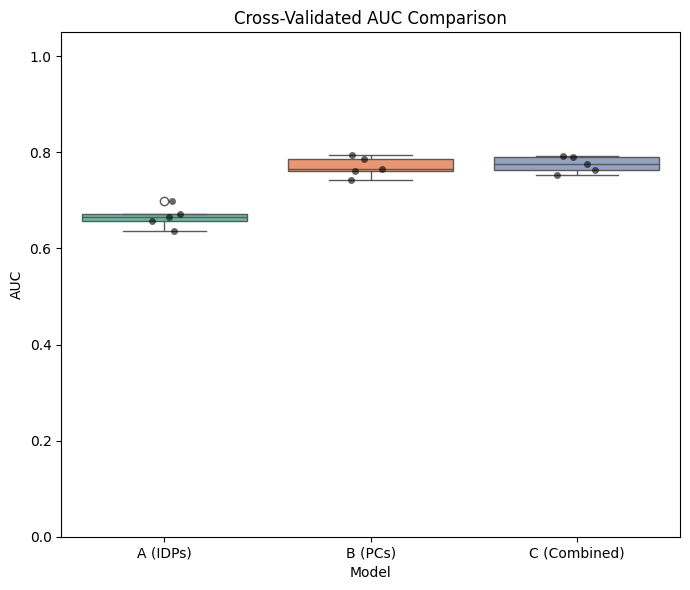

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2

############################
# Helper: Manual LRT
############################
def likelihood_ratio_test(model_small, model_large):
    ll_small = model_small.llf
    ll_large = model_large.llf
    df_small = model_small.df_model
    df_large = model_large.df_model

    lr_stat = 2.0 * (ll_large - ll_small)
    df_diff = int(df_large - df_small)
    p_value = chi2.sf(lr_stat, df_diff)
    
    return lr_stat, p_value, df_diff

############################
# 1) Prepare data
############################
df_model = idp_df.copy()
label_col = 'label'
df_model = df_model[[label_col] + idp_cols + pca_embedding_cols].dropna()
df_model = df_model.rename(columns={label_col: 'outcome'})
df_model['outcome'] = df_model['outcome'].astype(int)

# Build formulas
formula_idps = "outcome ~ " + " + ".join(idp_cols)       # Model A
formula_embs = "outcome ~ " + " + ".join(pca_embedding_cols)  # Model B
formula_both = "outcome ~ " + " + ".join(idp_cols + pca_embedding_cols)  # Model C

############################
# 2) Fit logistic models
############################
# Model A: IDPs
model_A = smf.logit(formula_idps, data=df_model).fit(disp=False)
print("=== Model A (IDPs) ===")
print(model_A.summary())

# Model B: Embeddings
model_B = smf.logit(formula_embs, data=df_model).fit(disp=False)
print("\n=== Model B (Embeddings) ===")
print(model_B.summary())

# Model C: IDPs + Embeddings
model_C = smf.logit(formula_both, data=df_model).fit(disp=False)
print("\n=== Model C (IDPs + Embeddings) ===")
print(model_C.summary())

############################
# 3) Likelihood Ratio Tests
############################
lr_stat_A_C, p_val_A_C, df_diff_A_C = likelihood_ratio_test(model_A, model_C)
lr_stat_B_C, p_val_B_C, df_diff_B_C = likelihood_ratio_test(model_B, model_C)

print("\n=== Likelihood Ratio Tests (Manual) ===")
print(f"Model A -> C: LR-stat={lr_stat_A_C:.3f}, df={df_diff_A_C}, p={p_val_A_C:.6f}")
print(f"Model B -> C: LR-stat={lr_stat_B_C:.3f}, df={df_diff_B_C}, p={p_val_B_C:.6f}")

############################
# 4) Cross-Validation AUC
############################
def cross_val_auc(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    clf = LogisticRegression(max_iter=1000, solver='liblinear')
    auc_list = []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)[:,1]
        auc_list.append(roc_auc_score(y_test, y_proba))
    return np.array(auc_list)

X_A = df_model[idp_cols].values
X_B = df_model[pca_embedding_cols].values
X_C = df_model[idp_cols + pca_embedding_cols].values
y   = df_model['outcome'].values

auc_scores_A = cross_val_auc(X_A, y)
auc_scores_B = cross_val_auc(X_B, y)
auc_scores_C = cross_val_auc(X_C, y)

print("\n=== Cross-Validation AUC ===")
print(f"Model A (IDPs)       : {auc_scores_A.mean():.3f} ± {auc_scores_A.std():.3f}")
print(f"Model B (PCs) : {auc_scores_B.mean():.3f} ± {auc_scores_B.std():.3f}")
print(f"Model C (Combined)   : {auc_scores_C.mean():.3f} ± {auc_scores_C.std():.3f}")

############################
# 5) Visualization
############################
results_df = pd.DataFrame({
    'AUC': np.concatenate([auc_scores_A, auc_scores_B, auc_scores_C]),
    'Model': (['A (IDPs)'] * len(auc_scores_A)
             + ['B (PCs)'] * len(auc_scores_B)
             + ['C (Combined)'] * len(auc_scores_C))
})

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, x='Model', y='AUC', palette='Set2')
sns.stripplot(data=results_df, x='Model', y='AUC', color='black', alpha=0.6)
plt.title('Cross-Validated AUC Comparison')
plt.ylabel('AUC')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_1426239/947466473.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lrt_results, x="Comparison", y="LR-Stat", palette="coolwarm", alpha=0.8)


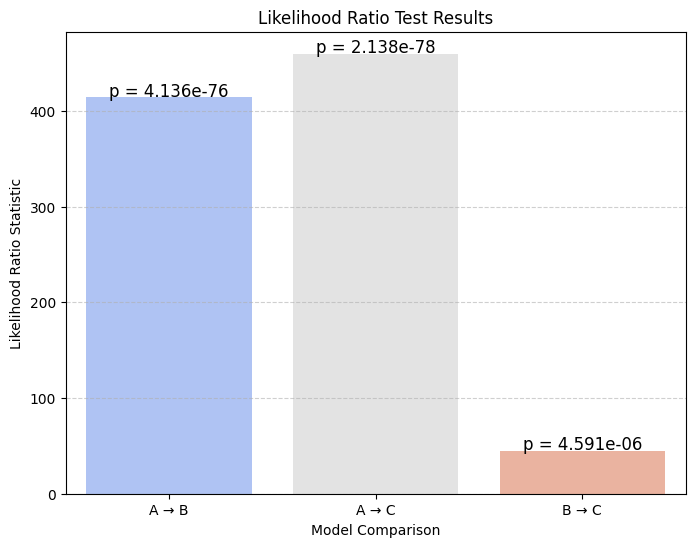

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

############################
# Helper: Likelihood Ratio Test Function
############################
def likelihood_ratio_test(model_small, model_large):
    ll_small = model_small.llf
    ll_large = model_large.llf
    df_small = model_small.df_model
    df_large = model_large.df_model

    lr_stat = 2.0 * (ll_large - ll_small)
    df_diff = int(df_large - df_small)
    p_value = chi2.sf(lr_stat, df_diff)
    
    return lr_stat, p_value, df_diff

############################
# 1) Prepare Data
############################
df_model = idp_df.copy()
label_col = 'label'
df_model = df_model[[label_col] + idp_cols + pca_embedding_cols].dropna()
df_model = df_model.rename(columns={label_col: 'outcome'})
df_model['outcome'] = df_model['outcome'].astype(int)

# Build formulas
formula_A = "outcome ~ " + " + ".join(idp_cols)               # Model A (IDPs)
formula_B = "outcome ~ " + " + ".join(pca_embedding_cols)     # Model B (PCA)
formula_C = "outcome ~ " + " + ".join(idp_cols + pca_embedding_cols)  # Model C (IDPs + PCA)

############################
# 2) Fit Logistic Regression Models
############################
# Model A: IDPs only
model_A = smf.logit(formula_A, data=df_model).fit(disp=False)

# Model B: PCA Embeddings only
model_B = smf.logit(formula_B, data=df_model).fit(disp=False)

# Model C: IDPs + PCA Embeddings
model_C = smf.logit(formula_C, data=df_model).fit(disp=False)

############################
# 3) Likelihood Ratio Tests (A→B, A→C, B→C)
############################
lr_stat_A_B, p_val_A_B, df_diff_A_B = likelihood_ratio_test(model_A, model_B)
lr_stat_A_C, p_val_A_C, df_diff_A_C = likelihood_ratio_test(model_A, model_C)
lr_stat_B_C, p_val_B_C, df_diff_B_C = likelihood_ratio_test(model_B, model_C)

lrt_results = pd.DataFrame({
    "Comparison": ["A → B", "A → C", "B → C"],
    "LR-Stat": [lr_stat_A_B, lr_stat_A_C, lr_stat_B_C],
    "DF Diff": [df_diff_A_B, df_diff_A_C, df_diff_B_C],
    "P-Value": [p_val_A_B, p_val_A_C, p_val_B_C]
})

# Save extended LRT results
lrt_results.to_csv("likelihood_ratio_tests_extended.csv", index=False)

############################
# 4) Visualization: LRT Results Bar Plot
############################
plt.figure(figsize=(8,6))
sns.barplot(data=lrt_results, x="Comparison", y="LR-Stat", palette="coolwarm", alpha=0.8)

# Annotate p-values on top of the bars
for i, p in enumerate(lrt_results["P-Value"]):
    plt.text(i, lrt_results["LR-Stat"][i] + 1, f"p = {p:.3e}", ha='center', fontsize=12)

plt.title("Likelihood Ratio Test Results")
plt.ylabel("Likelihood Ratio Statistic")
plt.xlabel("Model Comparison")
plt.grid(axis='y', linestyle="--", alpha=0.6)

# Save the updated LRT results plot
plt.savefig("lrt_results_extended_plot.png", dpi=300, bbox_inches="tight")
plt.show()
